# Введение

## Цель работы

Проанализировать данные о продаже компьютерных игр и выявить факторы, влияющие на успешность игры.


## План работы
1. Подготовка данных:
  - Замена названия столбцов.
  - Исправление ошибок в данных (пропуски, аномалии, дубликаты).
  - Приведение данных к нужным типам.
  - Добавление новых признаков (например, суммарные продажи).
2. Исследовательский анализ данных:
  - Анализ продаж игр по платформам, жанрам, годам.
  - Определение зависимости продаж от оценок критиков и пользователей.
  - Выявление самых популярных и прибыльных игр.
  - Исследование жизненного цикла игровых платформ.
3. Формулирование выводов и рекомендаций:
  - Описание потенциально популярного продукта.
  - Определение ключевых факторов, влияющих на продажи игр.
  - Рекомендации по планированию рекламных кампаний на 2017 год.

## Описание данных:
Набор данных содержит информацию о продажах компьютерных игр по всему миру до 2016 года. В нем представлены следующие характеристики:

- Название игры
- Платформа (например, PC, PS4, Xbox)
- Год выпуска
- Жанр
- Продажи в разных регионах (Северная Америка, Европа, Япония и другие)
- Оценки критиков и пользователей

# Предобработка данных

## Чтение данных

In [1]:
%%capture
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [3]:
try:
    df = pd.read_csv('games.csv', sep=',')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv', sep=',')

In [4]:
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

## Пример данных

In [5]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
11262,MetropolisMania,PS2,2001.00,Strategy,0.04,0.03,0.00,0.01,63.00,7.1,T
7746,Jissen Pachi-Slot Hisshouhou,SNES,1993.00,Misc,0.00,0.00,0.19,0.00,NaN,NaN,NaN
1009,Disney's Aladdin,SNES,1993.00,Platform,0.94,0.34,0.21,0.27,NaN,NaN,NaN
9309,Open Season,DS,2006.00,Platform,0.12,0.00,0.00,0.01,72.00,tbd,E
6347,Wipeout 2,X360,2011.00,Misc,0.25,0.00,0.00,0.02,NaN,tbd,E10+
5407,Yu-Gi-Oh! 5D's Tag Force 5,PSP,2010.00,Strategy,0.13,0.04,0.14,0.03,NaN,NaN,NaN
5574,NBA Street V3,XB,2005.00,Sports,0.28,0.03,0.00,0.01,89.00,8.9,E
16285,Satisfashion,Wii,2010.00,Misc,0.01,0.00,0.00,0.00,NaN,tbd,E
11370,Mortal Kombat Kollection,PS2,2008.00,Fighting,0.04,0.03,0.00,0.01,NaN,tbd,M
14845,Nekketsu Kouha Kunio-Kun SP: Rantou Kyousoukyoku,3DS,2013.00,Fighting,0.00,0.00,0.03,0.00,NaN,NaN,NaN


## Описание колонок

| Колонка | Старое название | Описание |
|---|---|---|
| `name` | `Name` | Название игры |
| `platform` | `Platform` | Платформа |
| `year_of_release` | `Year_of_Release` | Год выпуска |
| `genre` | `Genre` | Жанр игры |
| `na_sales` | `NA_sales` | продажи в Северной Америке (миллионы проданных копий) |
| `eu_sales` | `EU_sales` | продажи в Европе (миллионы проданных копий) |
| `jp_sales` | `JP_sales` | продажи в Японии (миллионы проданных копий) |
| `other_sales` | `Other_sales` | продажи в других странах (миллионы проданных копий) |
| `critic_score` | `Critic_Score` | оценка критиков (максимум 100) |
| `user_score` | `User_Score` | оценка пользователей (максимум 10) |
| `rating` | `Rating` | рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. |
| `total_sales` |  | суммарные продажи во всех регионах (миллионы проданных копий); `= na_sales + eu_sales + jp_sales + other_sales` |

Описание значений поля `rating`

| Рейтинг | Возраст | Комментарий |
|---|---|---|
| `EC` | 3 | Early childhood |
| `E` | 6 | Everyone |
| `E10+` | 10 | Everyone 10 and older |
| `T` | 13 | Teen |
| `M` | 17 | Mature |
| `AO` | 18 | Adults Only 18+ |

## Обзор данных

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Набор содержит 16715 записей.

Наименование полей следует скорректировать.

В некоторых полях есть значительные пропуски.

Изменить тип некоторых полей.

## Переименование колонок

Названия колонок перевести в нижний регистр.

In [7]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Удаление пропусков

Записи с пропусками в полях `Name`, `Year_of_Release` и `Genre` не содержат полезной информации для исследования. Их можно удалить, они составляют меньше 2% набора данных. Скорее всего, эти пропуски полностью случайны, возникли при вводе данных.

In [8]:
pd.DataFrame({
    '%': round(df.isna().mean()*100, 2),
    'Количество': df.isna().sum(),
}).sort_values(by='%', ascending=False).style.background_gradient('coolwarm')


,%,Количество
critic_score,51.320000,8578
rating,40.480000,6766
user_score,40.090000,6701
year_of_release,1.610000,269
name,0.010000,2
genre,0.010000,2
platform,0.000000,0
na_sales,0.000000,0
eu_sales,0.000000,0
jp_sales,0.000000,0


In [9]:
df = df.dropna(subset = ['name', 'year_of_release', 'genre'])

Поле `rating` категориальное, поэтому, для неизвестных значений можно установить общее значение `Unknown`, это не вызовет искажений в числовых расчетах.

In [10]:
df['rating'] = df['rating'].fillna('Unknown')
df['rating'].unique()

array(['E', 'Unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

[Описание системы рейтингов](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board)

Рейтинг `K-A` был переименован в `E`. Сделаем также.

`RP` означает `Rating Pending` или `Рейтинг ожидается`. Есть только одна такая запись. Для наших целей удобнее включить ее в рейтинг `Unknown`.

In [11]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'] = df['rating'].replace('RP', 'Unknown')

df['rating'].value_counts()


,count
rating,
Unknown,6677
E,3924
T,2905
M,1536
E10+,1393
EC,8
AO,1


## Дубликаты

In [12]:
df.duplicated().sum()

0

Явных дубликатов нет.

In [13]:
duplicates = df[df.duplicated(subset=['name', 'platform'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
1190,Need for Speed: Most Wanted,X360,2012.00,Racing,0.62,0.78,0.01,0.15,83.00,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.00,Racing,1.00,0.13,0.02,0.10,83.00,8.5,T
5972,Need for Speed: Most Wanted,PC,2005.00,Racing,0.02,0.23,0.00,0.04,82.00,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.00,Racing,0.00,0.06,0.00,0.02,82.00,8.5,T
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


Считаем, что перезапуски игр - это отдельные игры.
https://ru.wikipedia.org/wiki/Need_for_Speed:_Most_Wanted_(2012)

Поэтому, при поиске дубликатов учитываем год выпуска.


In [14]:
duplicates = df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.00,Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


Есть две записи об одной игре. Складываем суммы продаж.

In [15]:
# Группировать и суммировать значения sales
agg_functions = {
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'critic_score': 'max',
    'user_score': 'max',
    'rating': 'first',
}

df = df.groupby(['name', 'platform', 'year_of_release', 'genre']).agg(agg_functions).reset_index()

duplicates = df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]
duplicates

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


## Добавление вычисляемых полей

Поле `total_sales` описано выше.

In [16]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)

# Для проверки корреляций пригодиться допустимый возраст в числовом виде
def get_rating_age(rating):
    if rating == 'EC':
        return 3
    elif rating == 'E':
        return 6
    elif rating == 'E10+':
        return 10
    elif rating == 'T':
        return 13
    elif rating == 'M':
        return 17
    elif rating == 'AO':
        return 18
    else:
        return None
df['rating_age'] = df['rating'].apply(get_rating_age)


# Создаем словарь для соответствия жанров и чисел
# Добавляем новую колонку с цифровыми значениями жанров
genre_mapping = {genre: i for i, genre in enumerate(df['genre'].unique())}
df['genre_code'] = df['genre'].map(genre_mapping)

df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code
9131,NCAA Football 09,PSP,2008.00,Sports,0.21,0.00,0.00,0.02,NaN,tbd,E,0.23,6.00,3
1090,Beach Spikers: Virtua Beach Volleyball,GC,2002.00,Sports,0.08,0.02,0.00,0.00,76.00,8.1,E,0.10,6.00,3
30,100 All-Time Favorites,DS,2009.00,Puzzle,0.35,0.12,0.00,0.04,NaN,6.2,E,0.51,6.00,8
11105,Red Faction: Guerrilla,X360,2009.00,Shooter,0.48,0.29,0.01,0.09,85.00,8.1,M,0.87,17.00,6
3193,Disney Universe,X360,2011.00,Action,0.37,0.14,0.00,0.05,66.00,5.3,E10+,0.56,10.00,4


## Изменение типов данных

Привести поле `year_of_release` к типу данных `int`.

Привести поле `critic_score` к типу данных `float`. Пропущенные значения остаются NaN.

Привести поле `user_score` к типу данных `float`. Пропущенные значения остаются NaN. Не удалось найти корреляцию значения `tbd` (to be determined) с другими колонками. Скорее всего, это случайный пропуск. Так как восстановить данные мы не можем, конвертируем в `NaN`.

In [17]:
df['user_score_is_tbd'] = df['user_score'] == 'tbd'
df.corr(numeric_only=True)['user_score_is_tbd']

,user_score_is_tbd
year_of_release,0.07
na_sales,-0.07
eu_sales,-0.08
jp_sales,-0.10
other_sales,-0.07
critic_score,-0.23
total_sales,-0.09
rating_age,-0.34
genre_code,0.07
user_score_is_tbd,1.00


In [18]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['critic_score'] = df['critic_score'].astype('float')
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype('float')
df['user_score'] = df['user_score'].replace(0.0, np.nan)
df.dtypes

,0
name,object
platform,object
year_of_release,int64
genre,object
na_sales,float64
eu_sales,float64
jp_sales,float64
other_sales,float64
critic_score,float64
user_score,float64


## Описание данных

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16443 non-null  object 
 1   platform           16443 non-null  object 
 2   year_of_release    16443 non-null  int64  
 3   genre              16443 non-null  object 
 4   na_sales           16443 non-null  float64
 5   eu_sales           16443 non-null  float64
 6   jp_sales           16443 non-null  float64
 7   other_sales        16443 non-null  float64
 8   critic_score       7982 non-null   float64
 9   user_score         7461 non-null   float64
 10  rating             16443 non-null  object 
 11  total_sales        16443 non-null  float64
 12  rating_age         9766 non-null   float64
 13  genre_code         16443 non-null  int64  
 14  user_score_is_tbd  16443 non-null  bool   
dtypes: bool(1), float64(8), int64(2), object(4)
memory usage: 1.8+ MB


In [20]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code,user_score_is_tbd
12276,Silent Hill 2,PS2,2001,Action,0.62,0.49,0.00,0.16,89.00,8.90,M,1.27,17.00,4,False
1566,Brunswick Circuit Pro Bowling 2,PS,2000,Sports,0.06,0.04,0.00,0.01,NaN,NaN,Unknown,0.11,NaN,3,False
12280,Silent Hill 4: The Room,XB,2004,Action,0.14,0.04,0.00,0.01,76.00,8.30,M,0.19,17.00,4,False
15343,Valentino Rossi: The Game,PC,2016,Racing,0.00,0.01,0.00,0.00,72.00,6.20,E,0.01,6.00,5,False
14376,The Sims: Bustin' Out,PS2,2003,Simulation,1.07,1.19,0.00,0.18,81.00,8.40,T,2.44,13.00,9,False
14053,The Incredibles,PS2,2004,Action,0.96,1.08,0.04,0.30,62.00,7.60,T,2.38,13.00,4,False
6999,Kuroko's Basketball: Ties to Future,3DS,2015,Action,0.00,0.00,0.09,0.00,NaN,NaN,Unknown,0.09,NaN,4,False
6283,Jampack Summer 2K,PS,2000,Misc,0.88,0.60,0.00,0.10,NaN,NaN,Unknown,1.58,NaN,7,False
5515,Haneru no Tobira DS: Tanshuku Tetsudou no Yoru,DS,2007,Misc,0.00,0.00,0.04,0.00,NaN,NaN,Unknown,0.04,NaN,7,False
2992,Devil Kings,PS2,2005,Action,0.03,0.03,0.18,0.01,64.00,7.40,T,0.25,13.00,4,False


In [21]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,rating_age,genre_code
count,16443.00,16443.00,16443.00,16443.00,16443.00,7982.00,7461.00,16443.00,9766.00,16443.00
mean,2006.49,0.26,0.15,0.08,0.05,68.99,7.13,0.54,10.38,4.73
std,5.88,0.82,0.51,0.31,0.19,13.92,1.50,1.56,4.09,3.00
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.20,0.00,3.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40,0.06,6.00,3.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50,0.17,10.00,4.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20,0.47,13.00,7.00
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70,82.54,18.00,11.00


Есть существенные пропуски данных в полях `critic_score`, `user_score` и `rating`. Удалить столько записей нельзя, это слишком большой объем данных.

## Гистограммы числовых столбцов таблицы

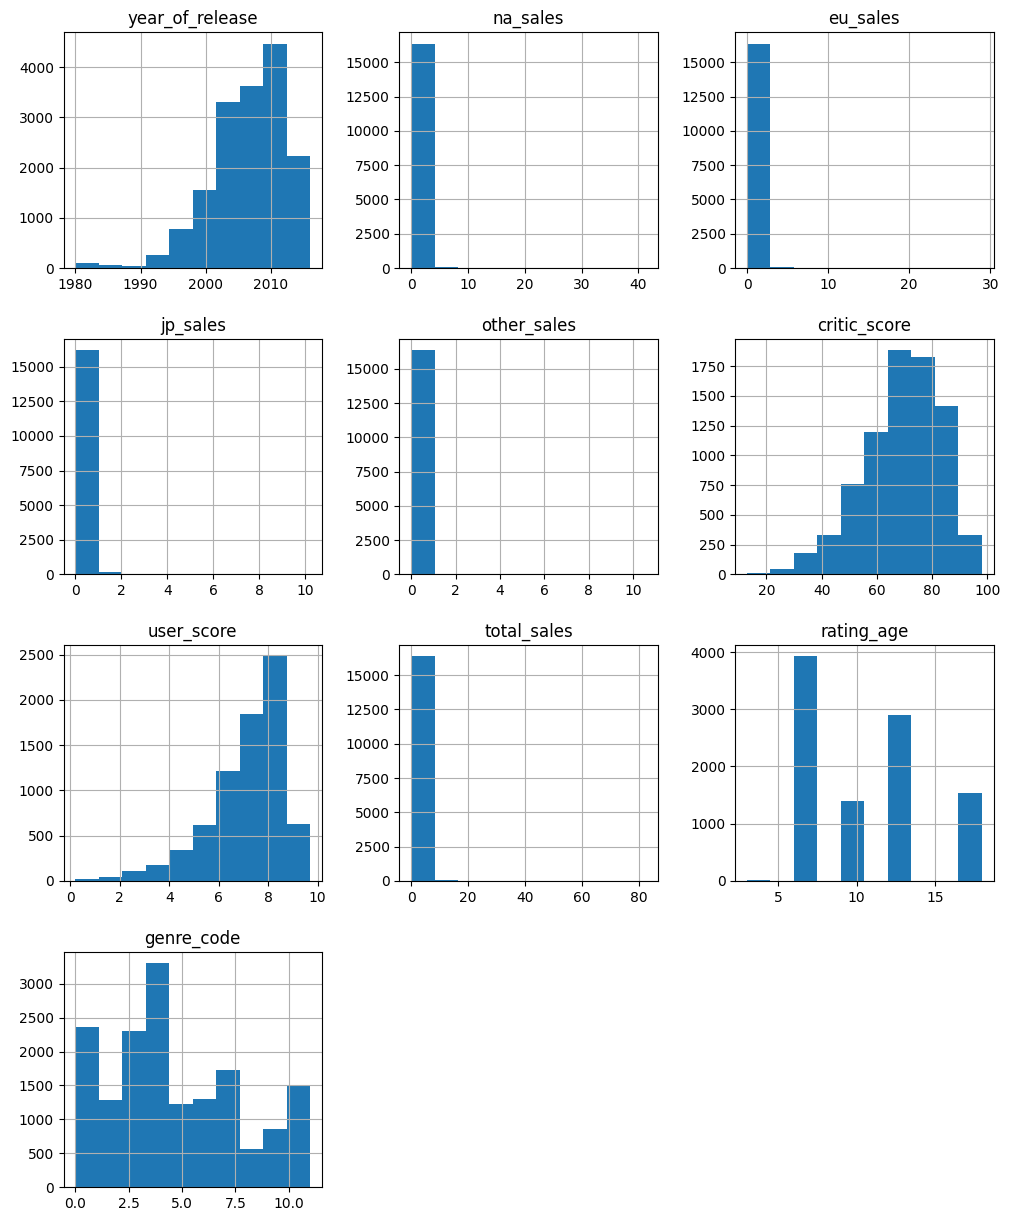

In [22]:
df.hist(figsize=(12, 15));

## Выводы

В рамках предобработки были:
- скорректированы названия и типы колонок, добавлены вычисляемые колонки для удобства дельнейшего анализа;
- удалены записи с явными пропусками, которые могли бы помешать анализу данных. Остались пропуски в колонках, которые мы не можем корректно заполнить. Необходимость заполнять поля искуственными данными в данный момент не видим, поэтому оставляем пропуски. Возможный алгоритм заполнения пропусков зависит от целей исследования.

В итоге из начальных 16715 записей осталось 16443. Предварительная обработка повлияла на объем данных в пределах 2%.

# Анализ данных

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Шаг 5. Напишите общий вывод

## Количество игр в разные годы

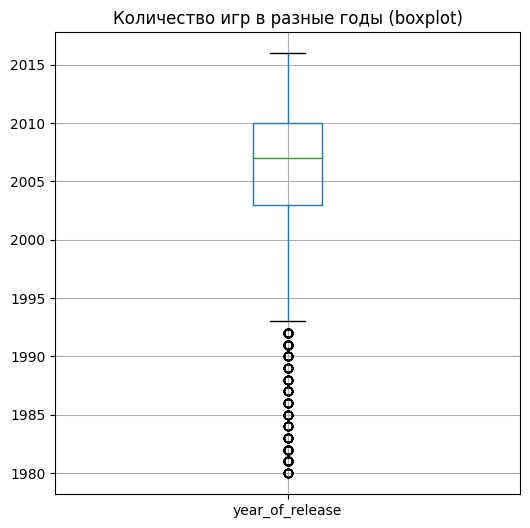

Нижний ус: 1992.5


In [23]:
df.boxplot('year_of_release',figsize=(6, 6))
plt.title('Количество игр в разные годы (boxplot)')
plt.show()

quartiles = df['year_of_release'].describe()
iqr = quartiles['75%'] - quartiles['25%']
print(f"Нижний ус:", quartiles['25%'] - 1.5 * iqr)

Значения раньше 1993 года считаем выбросами, эти данные не представляют интереса, можно удалить.

In [24]:
df = df[df['year_of_release'] >= 1993]

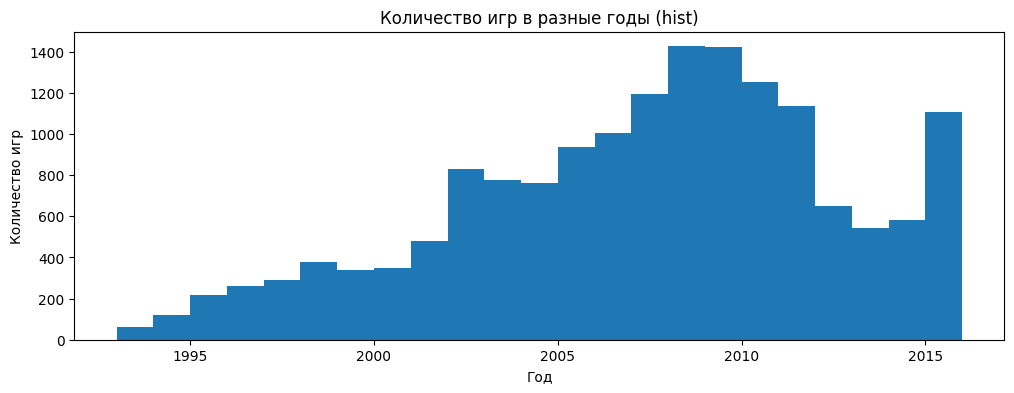

In [25]:
df['year_of_release'].plot(
    kind='hist',
    title='Количество игр в разные годы (hist)',
    xlabel='Год',
    ylabel='Количество игр',
    bins=len(df['year_of_release'].unique()) - 1,
    figsize=(12, 4),
)
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Наибольшее количество игр выпускалось в 2008 и 2009 годах.

## Игровые платформы

In [26]:
print('Общее количество платформ:', len(df['platform'].unique()))

Общее количество платформ: 29


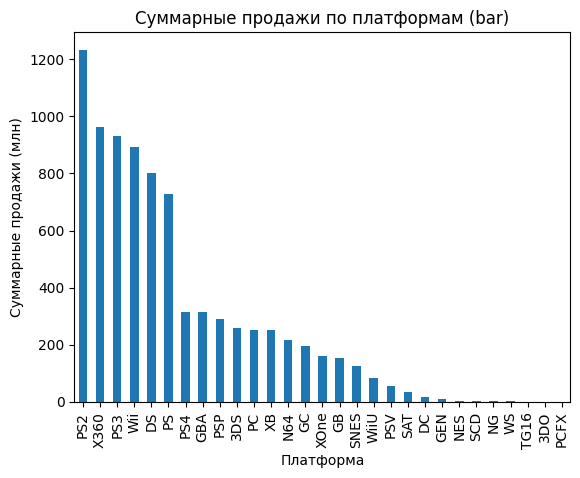

In [27]:
platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platforms.plot(
    kind='bar',
    title='Суммарные продажи по платформам (bar)',
)
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

In [28]:
platforms = df.groupby('platform').agg(
    total_sales=('total_sales', 'sum'),
    year_min=('year_of_release', 'min'),
    year_max=('year_of_release', 'max')
).reset_index().sort_values(by='total_sales', ascending=False)
platforms

,platform,total_sales,year_min,year_max
14,PS2,1233.56,2000,2011
26,X360,961.24,2005,2016
15,PS3,931.34,2006,2016
24,Wii,891.18,2006,2016
3,DS,802.76,2004,2013
13,PS,727.58,1994,2003
16,PS4,314.14,2013,2016
5,GBA,312.88,2000,2007
17,PSP,289.53,2004,2015
1,3DS,257.81,2011,2016


In [29]:
top_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
print('Наиболее популярные платформы за все время:')
print(*top_platforms, sep=', ')

Наиболее популярные платформы за все время:
PS2, X360, PS3, Wii, DS


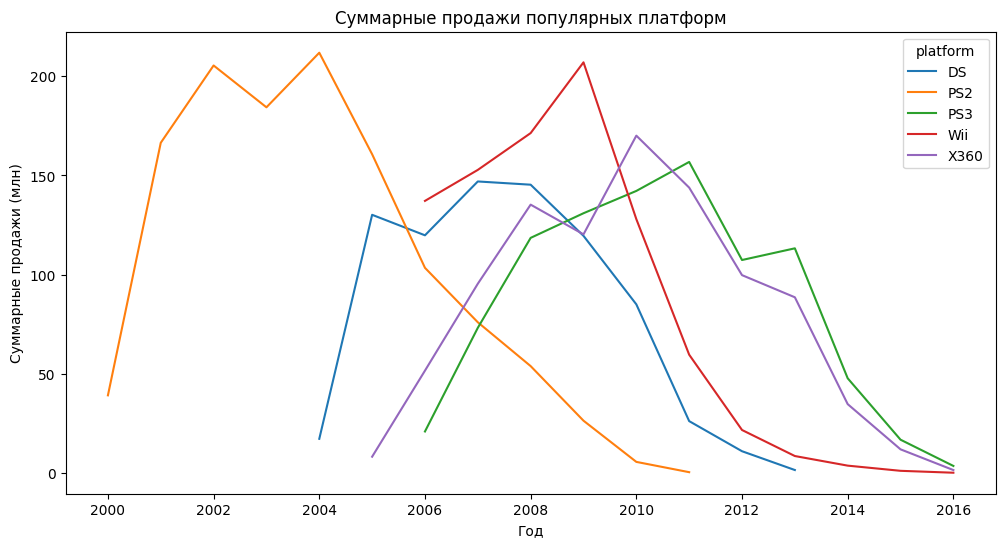

In [30]:
df_top = df[df['platform'].isin(top_platforms)]
# create a pivot table with platforms as columns and years as rows
platform_sales = df_top.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
# plot the sales for each platform
platform_sales.plot(kind='line', figsize=(12, 6))
plt.title('Суммарные продажи популярных платформ')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

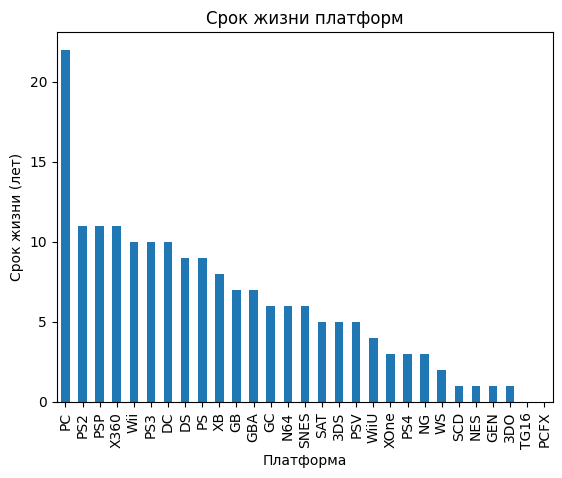

In [31]:
lifespan_all = df.groupby('platform')['year_of_release'].agg(['min', 'max'])
lifespan_all['lifespan'] = lifespan_all['max'] - lifespan_all['min']
lifespan_all = lifespan_all.sort_values(by='lifespan', ascending=False)

lifespan_all['lifespan'].plot(
    kind='bar',
    title='Срок жизни платформ',
    xlabel='Платформа',
    ylabel='Срок жизни (лет)',
);

In [32]:
lifespan_all['lifespan'].describe()

,lifespan
count,29.00
mean,6.10
std,4.72
min,0.00
25%,3.00
50%,6.00
75%,9.00
max,22.00


In [33]:
lifespan_top = df[df['platform'].isin(top_platforms)].groupby('platform')['year_of_release'].agg(['min', 'max'])
lifespan_top['lifespan'] = lifespan_top['max'] - lifespan_top['min']

lifespan_top['lifespan'].describe()

,lifespan
count,5.00
mean,10.20
std,0.84
min,9.00
25%,10.00
50%,10.00
75%,11.00
max,11.00


Средний и медианный срок жизни платформы 6 лет.

Средний и медианный срок жизни популярных платформ 10 лет.


## Актуальный период

Будем рассматривать данные за 2014-2016 годы.

Представляется разумным выбрать актуальный период 2-3 года.

Данные за 1 год не позволят выявить тенденции.

Срок жизни платформы около 10 лет — это слишком большой период для анализа, так как за это время рынок игр может сильно измениться, появляются новые жанры, технологии и тренды.

Использование данных за 2-3 года позволит:
- Учесть актуальные тенденции: В игровой индустрии тренды меняются очень быстро. Данные за 2-3 года отражают текущую ситуацию на рынке.
- Сосредоточиться на жизненном цикле популярных платформ: Большинство платформ не существуют 10 лет. Анализ данных за 2-3 года позволит оценить продажи на пике популярности платформ и сделать более точный прогноз.
- Исключить влияние устаревших данных: Игры, выпущенные 5-10 лет назад, не релевантны для прогнозирования продаж в 2017 году.

Таким образом, анализ данных за 2-3 года позволит построить более точный прогноз на 2017 год, учитывая динамику рынка и жизненный цикл игровых платформ.

Данные за актуальный период храним в переменной `df3`.

In [34]:
df3 = df[df['year_of_release'] >= 2014].sort_values(by='total_sales', ascending=False)
df3['total_sales'] = df3[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
df3.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_age,genre_code,user_score_is_tbd
15700,Watch Dogs,PS4,2014,Action,1.40,1.90,0.11,0.64,80.00,6.30,M,4.05,17.00,4,False
343,Alien: Isolation,PS3,2014,Shooter,0.12,0.16,0.00,0.05,NaN,8.30,M,0.33,17.00,6,False
5455,Hakuoki: Shinkai - Furi no Shou,PSV,2015,Action,0.00,0.00,0.02,0.00,NaN,NaN,Unknown,0.02,NaN,4,False
13349,Super Robot Wars OG Saga Masou Kishin F: Coffi...,PS3,2014,Strategy,0.00,0.00,0.06,0.00,NaN,NaN,Unknown,0.06,NaN,10,False
5681,Hearts of Iron IV,PC,2016,Strategy,0.00,0.05,0.00,0.00,83.00,6.90,Unknown,0.05,NaN,10,False


## Продажи платформ

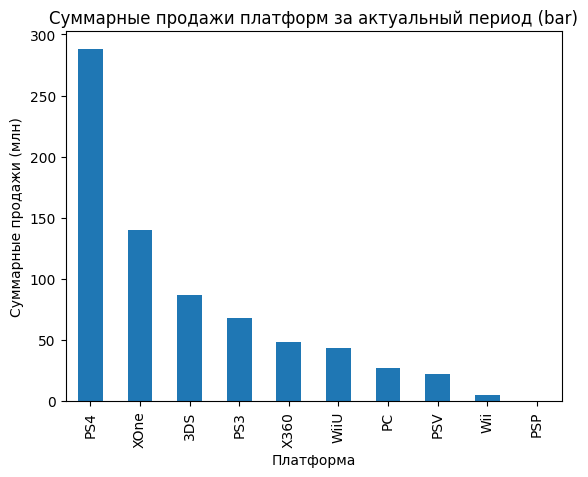

In [35]:
platforms3 = df3.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platforms3.plot(
    kind='bar',
    title='Суммарные продажи платформ за актуальный период (bar)',
    xlabel='Платформа',
    ylabel='Суммарные продажи (млн)',
)
plt.show()

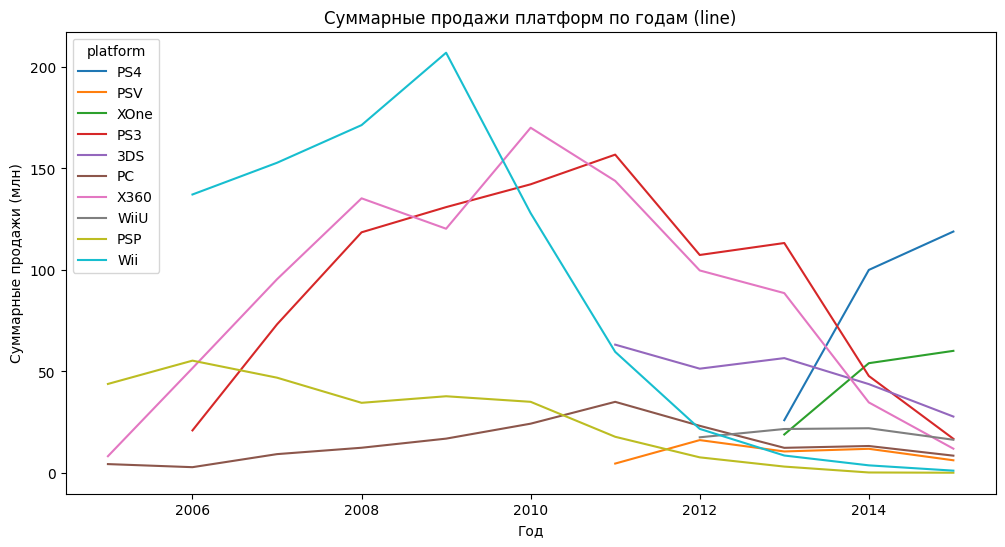

In [36]:
platform_sales = df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
# Отображаем только актуальные платформы
platform_sales = platform_sales[df3['platform'].value_counts().index]
platform_sales = platform_sales[platform_sales.index >= 2005]
platform_sales = platform_sales[platform_sales.index <= 2015]
platform_sales.plot(kind='line', figsize=(12, 6))
plt.title('Суммарные продажи платформ по годам (line)')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи (млн)')
plt.show()

Данные за 2016 год неполные, поэтому не рассматриваем их для оценки динамики. Видно, что растут только PS4 и XOne. Они же лидеры по продажам.

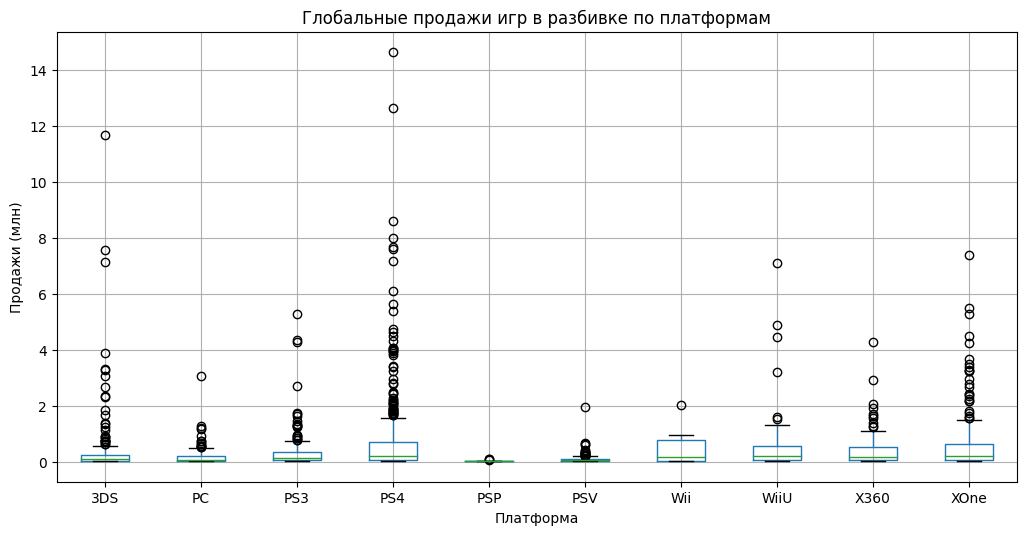

In [37]:
df3.boxplot('total_sales', by='platform', figsize=(12, 6))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн)')
plt.show()

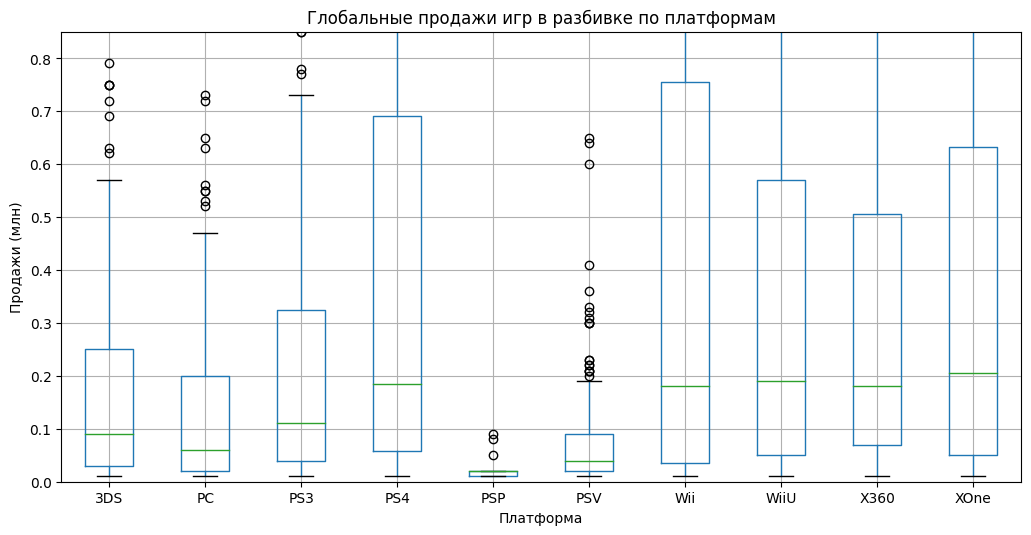

In [38]:
df3.boxplot('total_sales', by='platform', figsize=(12, 6))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн)')
plt.ylim(0, 0.85)
plt.show()

In [39]:
df3.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.00,0.41,1.19,0.01,0.03,0.09,0.25,11.68
PC,151.00,0.18,0.33,0.01,0.02,0.06,0.20,3.05
PS3,219.00,0.31,0.63,0.01,0.04,0.11,0.33,5.27
PS4,376.00,0.77,1.61,0.01,0.06,0.18,0.69,14.63
PSP,13.00,0.03,0.03,0.01,0.01,0.02,0.02,0.09
PSV,295.00,0.08,0.14,0.01,0.02,0.04,0.09,1.96
Wii,11.00,0.46,0.63,0.01,0.04,0.18,0.76,2.01
WiiU,73.00,0.59,1.16,0.01,0.05,0.19,0.57,7.09
X360,111.00,0.43,0.63,0.01,0.07,0.18,0.51,4.28


Потенциально прибыльными платформами можно считать PS4 и XOne.
Высокая медиана: Медиана продаж на этих платформах выше, чем у большинства других. Это говорит о том, что в среднем игры на PS4 и XOne продаются лучше.
Большой разброс: Усы на графике для PS4 и XOne довольно длинные, что указывает на больший потенциал для высоких продаж.

## Отзывы пользователей и критиков

In [40]:
print('Коэффициенты корреляции между продажами и оценкой пользователей')
print('PS4:', df[df['platform'] == 'PS4']['total_sales'].corr(df[df['platform'] == 'PS4']['user_score']))
print('XOne:', df[df['platform'] == 'XOne']['total_sales'].corr(df[df['platform'] == 'XOne']['user_score']))

print('Коэффициенты корреляции между продажами и оценкой критиков')
print('PS4:', df[df['platform'] == 'PS4']['total_sales'].corr(df[df['platform'] == 'PS4']['critic_score']))
print('XOne:', df[df['platform'] == 'XOne']['total_sales'].corr(df[df['platform'] == 'XOne']['critic_score']))

Коэффициенты корреляции между продажами и оценкой пользователей
PS4: -0.0319571102045564
XOne: -0.06892505328279423
Коэффициенты корреляции между продажами и оценкой критиков
PS4: 0.4065679020617813
XOne: 0.4169983280084019


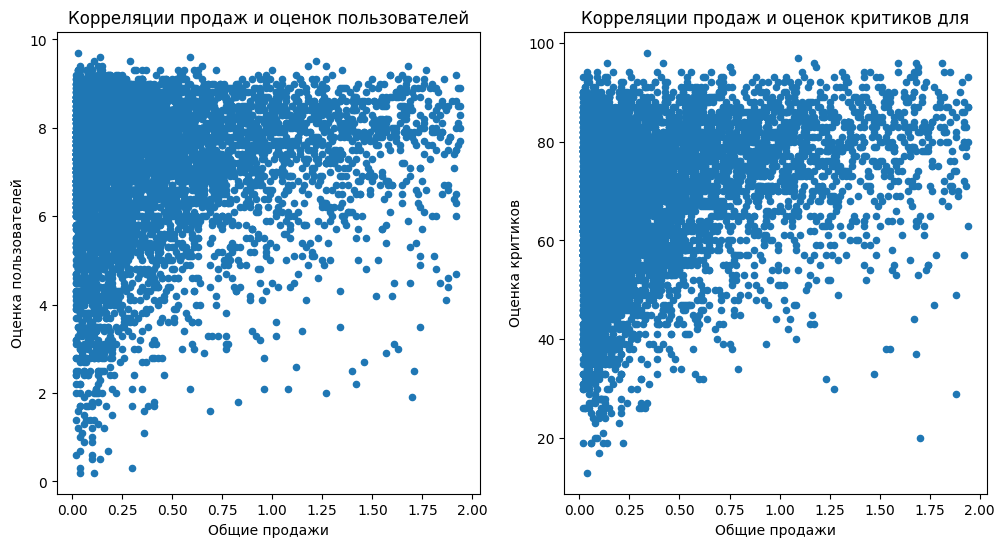

In [41]:
lower_bound = df['total_sales'].quantile(0.05)
upper_bound = df['total_sales'].quantile(0.95)
filtered_data = df[(df['total_sales'] >= lower_bound) & (df['total_sales'] <= upper_bound)]

# Создаем сетку подграфиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График для user_score
filtered_data.plot(x='total_sales', y='user_score', kind='scatter', ax=axes[0])
axes[0].set_title(f'Корреляции продаж и оценок пользователей')
axes[0].set_ylabel('Оценка пользователей')
axes[0].set_xlabel(f'Общие продажи')

# График для critic_score
filtered_data.plot(x='total_sales', y='critic_score', kind='scatter', ax=axes[1])
axes[1].set_title(f'Корреляции продаж и оценок критиков для')
axes[1].set_ylabel('Оценка критиков')
axes[1].set_xlabel(f'Общие продажи')

plt.show()

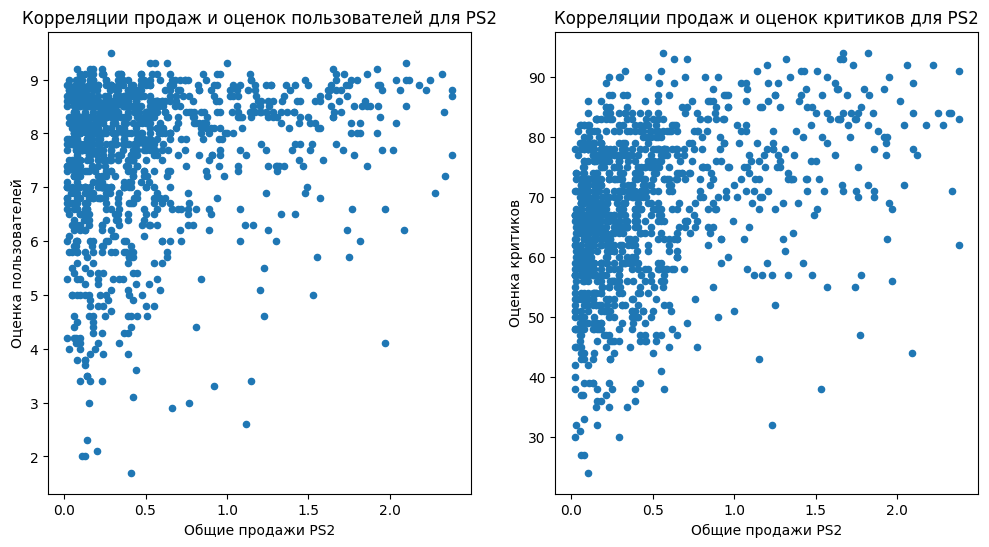

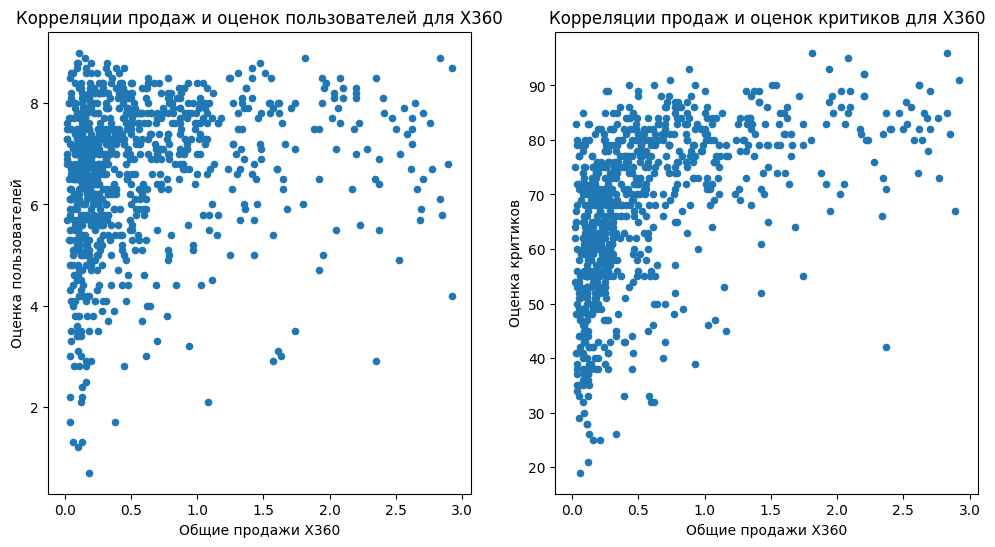

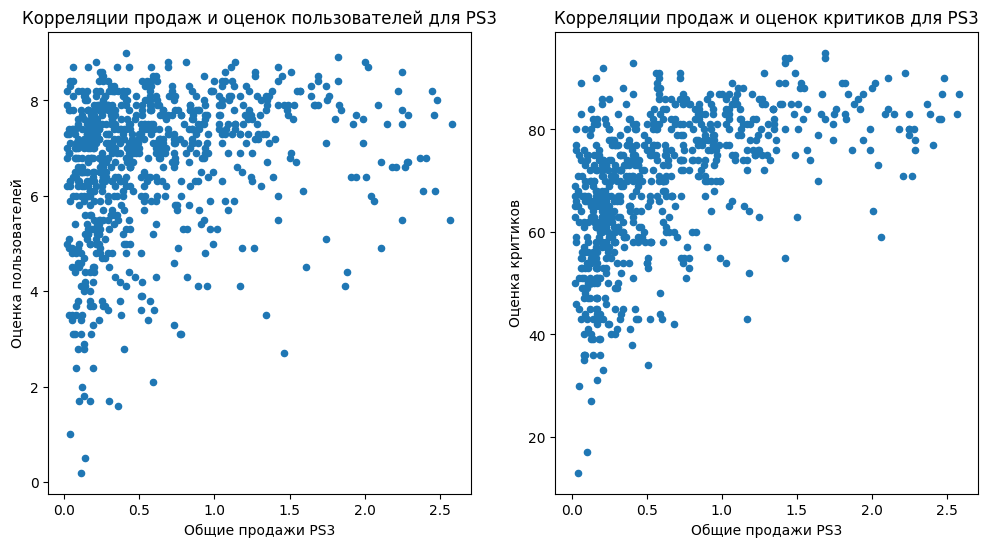

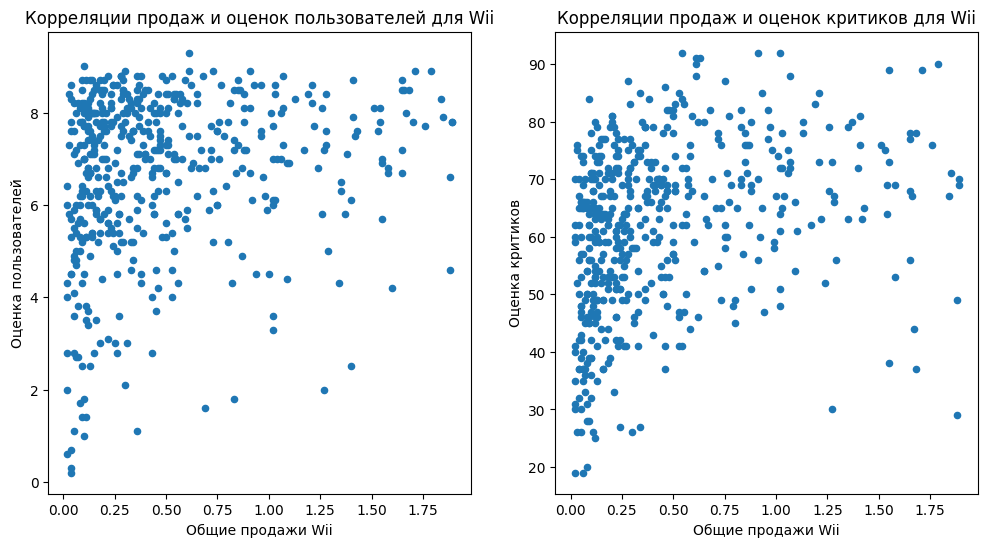

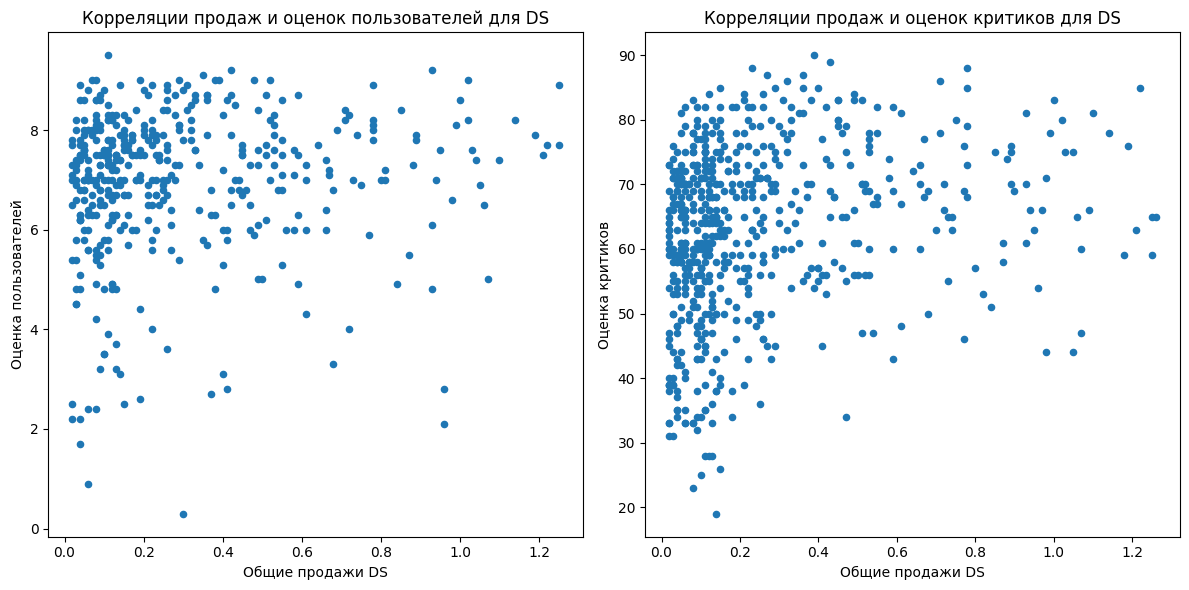

In [42]:
for platform in top_platforms:
    # Фильтруем данные для текущей платформы
    platform_data = df[df['platform'] == platform]
    lower_bound = platform_data['total_sales'].quantile(0.05)
    upper_bound = platform_data['total_sales'].quantile(0.95)
    platform_data = platform_data[(platform_data['total_sales'] >= lower_bound) & (platform_data['total_sales'] <= upper_bound)]

    # Создаем сетку подграфиков
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # График для user_score
    platform_data.plot(x='total_sales', y='user_score', kind='scatter', ax=axes[0])
    axes[0].set_title(f'Корреляции продаж и оценок пользователей для {platform}')
    axes[0].set_ylabel('Оценка пользователей')
    axes[0].set_xlabel(f'Общие продажи {platform}')

    # График для critic_score
    platform_data.plot(x='total_sales', y='critic_score', kind='scatter', ax=axes[1])
    axes[1].set_title(f'Корреляции продаж и оценок критиков для {platform}')
    axes[1].set_ylabel('Оценка критиков')
    axes[1].set_xlabel(f'Общие продажи {platform}')

# Отображение графиков
plt.tight_layout()
plt.show()

Исходя из значений корреляции Пирсона можно сделать выводы:
- Оценка критиков имеет слабую корреляцию с продажами.
- Оценка пользователей никак не влияет на продажи.

Диаграммы рассеяния для всех платформ вместе и для нескольких самых популярных платформ показывают, что хорошие отзывы не гарантируют хорошие продажи, но плохие отзывы гарантируют, что продажи будут низкими. Практически нет игр с плохими отзывами и хорошими продажами.

Для большей наглядности при построении графиком были исключены артефакты в виде 5% самых высоких и самых низких продаж, не отражающие типичную ситуацию.

## Жанры игр

In [43]:
pd.DataFrame({
    'Количество': df3['genre'].value_counts(),
    '%': df3['genre'].value_counts(normalize=True) * 100
})

,Количество,%
genre,,
Action,619,36.65
Role-Playing,221,13.08
Adventure,185,10.95
Sports,161,9.53
Shooter,128,7.58
Misc,113,6.69
Racing,69,4.09
Fighting,60,3.55
Simulation,44,2.61


In [44]:
df3.groupby('genre')['total_sales'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,128.00,1.34,2.05,0.01,0.17,0.52,1.62,14.63
Sports,161.00,0.68,1.24,0.01,0.06,0.18,0.64,8.58
Platform,38.00,0.48,0.72,0.01,0.06,0.14,0.47,3.21
Fighting,60.00,0.47,1.19,0.01,0.06,0.12,0.32,7.55
Role-Playing,221.00,0.46,1.18,0.01,0.05,0.11,0.36,11.68
Racing,69.00,0.40,0.96,0.01,0.03,0.09,0.25,7.09
Misc,113.00,0.33,0.74,0.01,0.03,0.09,0.32,5.27
Action,619.00,0.32,0.80,0.01,0.03,0.09,0.28,12.62
Simulation,44.00,0.30,0.65,0.01,0.02,0.10,0.33,3.05


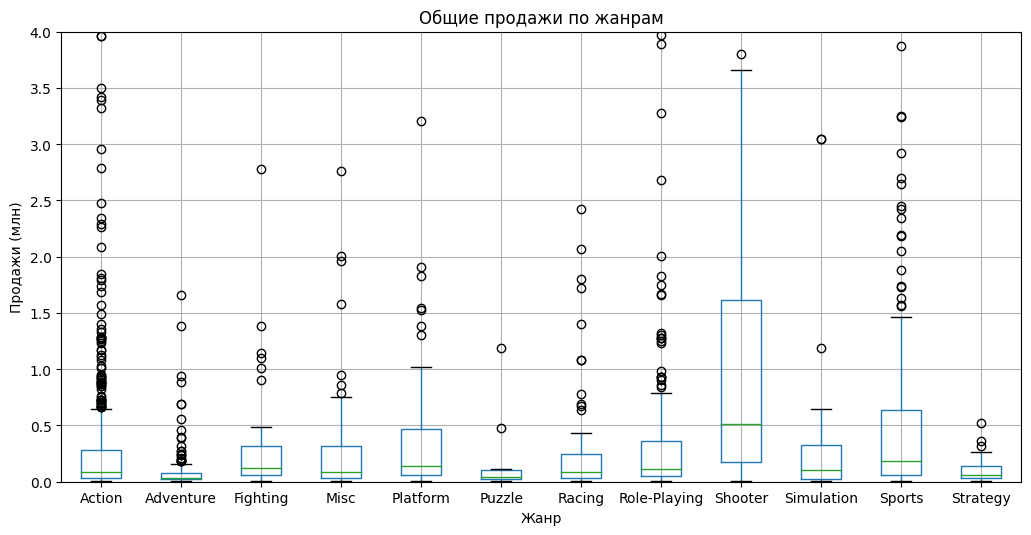

In [45]:
df3.boxplot('total_sales', by='genre',figsize=(12,6)).set_ylim([0, 4])
plt.title('Общие продажи по жанрам')
plt.suptitle('')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн)')
plt.show()

Наиболее часто встречаемый жанр - `Action`.
Больше всего продаж у игр жанра `Shooter`.

## Регионы

Определите для пользователя каждого региона (NA, EU, JP):

    Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    Самые популярные жанры (топ-5). Поясните разницу.
    Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [46]:
top_platforms_region = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    print(f"Топ-5 платформ для региона {region}:")
    platforms_region = df3.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
    print(*platforms_region.index, sep=', ')
    print()
    # Список наиболее популярных платформ в разных регионах
    top_platforms_region.update(platforms_region.index)

Топ-5 платформ для региона na_sales:
PS4, XOne, X360, 3DS, PS3

Топ-5 платформ для региона eu_sales:
PS4, XOne, PS3, PC, 3DS

Топ-5 платформ для региона jp_sales:
3DS, PS4, PSV, PS3, WiiU



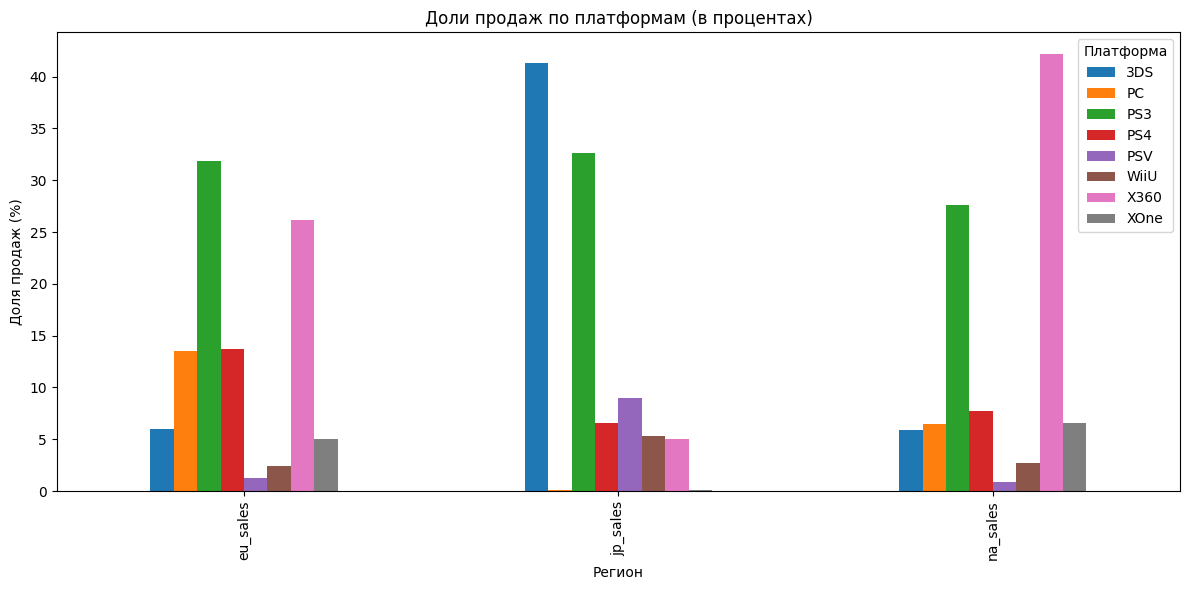

In [47]:
# Для ясности рассматриваем только самые популярные платформы
df_platforms = df[df['platform'].isin(top_platforms_region)]
sales_by_platform = df_platforms.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
total_sales = df_platforms[['na_sales', 'eu_sales', 'jp_sales']].sum()
sales_by_platform_share = sales_by_platform.div(total_sales) * 100

sales_by_platform_share.T.plot(kind='bar', figsize=(12, 6))
plt.title('Доли продаж по платформам (в процентах)')
plt.xlabel('Регион')
plt.ylabel('Доля продаж (%)')
plt.legend(title='Платформа')
plt.tight_layout()
plt.show()

Рынки Северной Америки и Европы похожи. В Японии популярны другие платформы.

Разница в популярности платформ может объясняться несколькими факторами:

Культурные особенности: В Японии традиционно сильна портативная игровая культура, что объясняет высокую популярность 3DS и PSV.
Маркетинговые стратегии: Компании могут делать акцент на продвижение определенных платформ в разных регионах.
Эксклюзивные игры: Наличие эксклюзивных игр на платформе может существенно влиять на ее продажи в конкретном регионе.

In [48]:
top_genres_region = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    print(f"Топ-5 жанров для региона {region}:")
    genres_region = df3.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    print(*genres_region.index, sep=', ')
    print()
    # Список наиболее популярных жанров в разных регионах
    top_genres_region.update(genres_region.index)

Топ-5 жанров для региона na_sales:
Shooter, Action, Sports, Role-Playing, Misc

Топ-5 жанров для региона eu_sales:
Action, Shooter, Sports, Role-Playing, Racing

Топ-5 жанров для региона jp_sales:
Role-Playing, Action, Fighting, Misc, Shooter



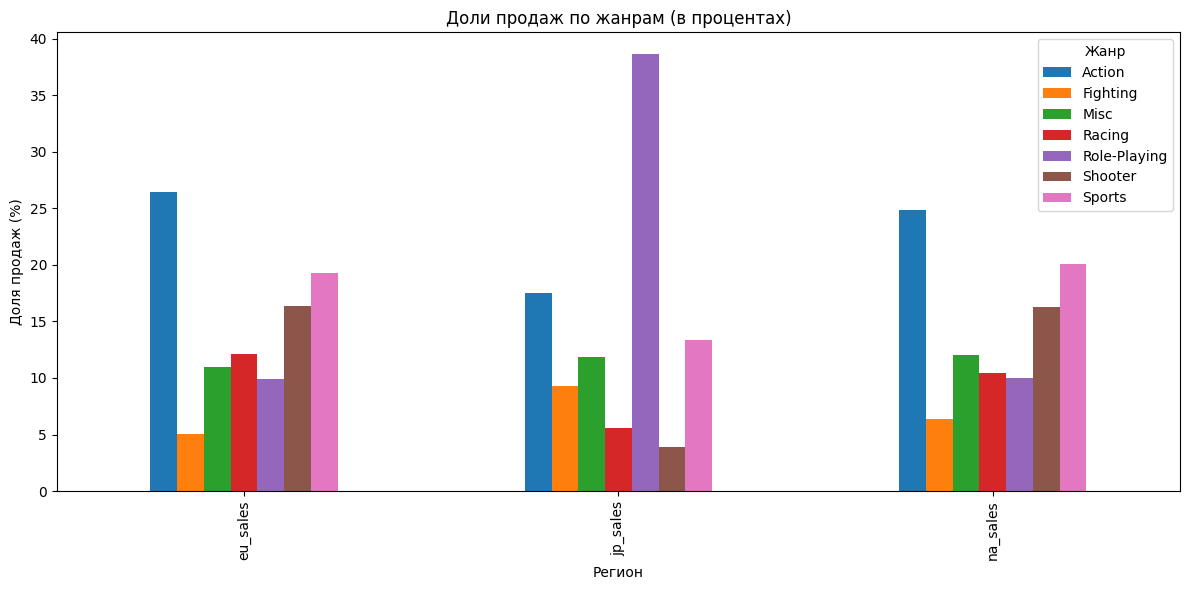

In [49]:
# Для ясности рассматриваем только самые популярные жанры
df_genres = df[df['genre'].isin(top_genres_region)]
sales_by_genre = df_genres.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
total_sales = df_genres[['na_sales', 'eu_sales', 'jp_sales']].sum()
sales_by_genre_share = sales_by_genre.div(total_sales) * 100

sales_by_genre_share.T.plot(kind='bar', figsize=(12, 6))
plt.title('Доли продаж по жанрам (в процентах)')
plt.xlabel('Регион')
plt.ylabel('Доля продаж (%)')
plt.legend(title='Жанр')
plt.tight_layout()
plt.show()

В Северной Америке и Европе лидируют Action, Shooter и Sports. В Японии Role-Playing занимает первое место, а Action только четвертое.

Это может быть связано с культурными особенностями и предпочтениями игроков в разных регионах. Возможно, в Японии большую роль играет сюжет и глубина игрового мира, которые характерны для жанра Role-Playing. В Северной Америке и Европе, скорее всего, ценятся динамика и экшен, что отражается в популярности Action и Shooter.

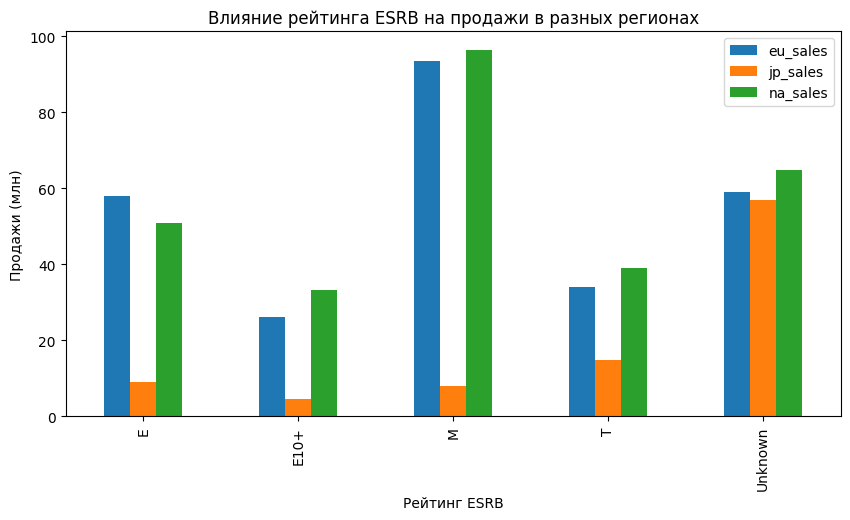

In [50]:
# Создаем сводную таблицу
sales_by_rating = df3.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

# Строим график
sales_by_rating.plot(kind='bar', figsize=(10, 5))
plt.title('Влияние рейтинга ESRB на продажи в разных регионах')
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи (млн)')
plt.show()

Влияние рейтинга ESRB на продажи различается в зависимости от региона.

В Северной Америке и Европе игры с рейтингом "M" (Mature) имеют наибольшие продажи.
В Японии игры с рейтингом "T" (Teen) продаются лучше всего.

Продажи игр без рейтинга примерно одинаковы во всех регионах. Возможно, в исходных данных рейтинг пропущен полностью случайно, поэтому в него равномерно попадают игры всех рейтингов.

# Общий вывод

В ходе работы был проведен анализ данных о продаже компьютерных игр с 1993 по 2016 год. Исходный набор данных содержит информацию о 16715 играх, включая название, платформу, год выпуска, жанр, продажи в разных регионах и оценки.

## Предобработка данных

В некоторых полях есть существенные пропуски. Поле critic_score (оценка критиков) заполнено в 51% записей, user_score (оценка пользователей) 40%, rating (возрастной рейтинг) 40%.

Для подготовки данных к анализу были выполнены следующие действия:

- Скорректированы названия и типы данных в столбцах.
- Удалены дубликаты и пропуски в данных.
- Добавлены новые столбцы для удобства анализа (суммарные продажи).

## Анализ продаж

Динамика продаж: Наибольшее количество игр было продано в 2008 и 2009 годах (1400 наименований).

Популярные платформы: Самыми популярными платформами за весь период являются PS2 (1234 млн), X360 (961 млн), PS3 (931 млн).

Средний срок жизни популярной платформы составляет 10 лет.

Влияние оценок: Обнаружена слабая корреляция между оценками критиков и продажами. Оценки пользователей не оказывают существенного влияния на продажи.
Хорошие отзывы критиков и пользователей не гарантируют, но являются необходимым условием для хороших продаж. Практически нет игр с плохими отзывами и хорошими продажами.

Популярные жанры: Самыми распространными жанрами являются Action (36%), Role-Playing (13%), Adventure (11%), Sports (10%) и Shooter (8%).

Региональные различия: В Северной Америке и Европе наиболее популярны игры жанров Action, Shooter и Sports, в то время как в Японии лидирует жанр Role-Playing, а жанр Shooter наименее популярен.
В Северной Америке и Европе наиболее популярны платформы X360, PS3, PS4. В Японии популярны 3DS, PS3 и PSV.

Влияние рейтинга ESRB на продажи различается в зависимости от региона. В Северной Америке и Европе игры с рейтингом "M" (Mature) имеют наибольшие продажи. В Японии игры с рейтингом "T" (Teen) продаются лучше всего.

## Выводы и рекомендации

Рынок компьютерных игр динамично развивается, появляются новые платформы и жанры.
При планировании рекламных кампаний на 2017 год рекомендуется учитывать региональные особенности, а также обратить внимание на перспективные платформы PS4 и XOne.

Наиболее популярные жанры - Action, Shooter и Sports. Лучшие продажи показывают Shooter и Sports.

Оценки критиков оказывают некоторое влияние на продажи, поэтому важно обеспечить положительные отзывы прессы.